In [1]:
using Flux, Flux.Data.MNIST
using Flux: onehotbatch, argmax, crossentropy, throttle
using Base.Iterators: repeated
using FluxExtensions
using MLBase: roc, correctrate, precision, recall, f1score, false_positive_rate, false_negative_rate

push!(LOAD_PATH, "../", "/home/jan/dev/anomaly detection/anomaly_detection/src")
using KNNmem
using AnomalyDetection

include("../train_and_track.jl");

In [2]:
# Prepare data

dataPath = "/home/jan/dev/data/loda/public/datasets/numerical"
allData = AnomalyDetection.loaddata(dataPath)

dataset = allData["musk-2"]
train, test, clusterdness = AnomalyDetection.makeset(dataset, 0.9, "normal", 0.5, "high")
inputSize = size(train.data, 1)

166

In [3]:
# Model with memory

memoryModel = Chain(
  FluxExtensions.ResDense(inputSize, 32, relu),
  FluxExtensions.ResDense(32, 2, relu))

memory = KNNmemory(2000, 2, 64, 10)

# Model without memory

classicModel = Chain(
  FluxExtensions.ResDense(inputSize, 32, relu),
  FluxExtensions.ResDense(32, 2, relu),
  softmax)

Chain(ResDense(Dense(32, 32, NNlib.relu)), ResDense(Dense(2, 2, NNlib.relu)), NNlib.softmax)

In [4]:
# Training setup

memLoss(x, y) = trainQuery!(memory, memoryModel(x), y)
memPerformance(x, y) = mean(query(memory, memoryModel(x)) .== y)
memOpt = ADAM(params(memoryModel))

classicLoss(x, y) = Flux.mse(classicModel(x), y)
classicOpt = ADAM(params(classicModel))
classicPerformance(x, y) = mean(argmax(classicModel(x)) .== argmax(y))

iterations = 100
batchSize = 1000
printInterationCount = 10

10

In [5]:
memHistory = trainAndTrack!(memLoss, memPerformance, memOpt, iterations, batchSize, train.data, train.labels, test.data, test.labels, printInterationCount)
classicHistory = trainAndTrack!(classicLoss, classicPerformance, classicOpt, iterations, batchSize, train.data, Flux.onehotbatch(train.labels, 0:1), test.data, Flux.onehotbatch(test.labels, 0:1), printInterationCount)

0.09998586625034794
0.09998242990952455
0.09996167946829952
0.09999360851793915
0.09999801483211262
0.10005391787686037
0.09999339208126354
0.0999819982709773
0.09999144483276164
0.09998507654738921
0.2239768122958109
0.19093802860772496
0.1837312560823872
0.19556115170202304
0.1824676859209319
0.19418658581154183
0.18671579414794418
0.18117082642408394
0.18135391923483044
0.18013682041917212


MVHistory{ValueHistories.History}
  :performance => 10 elements {Int64,Float64}
  :trainLoss => 10 elements {Int64,Float64}

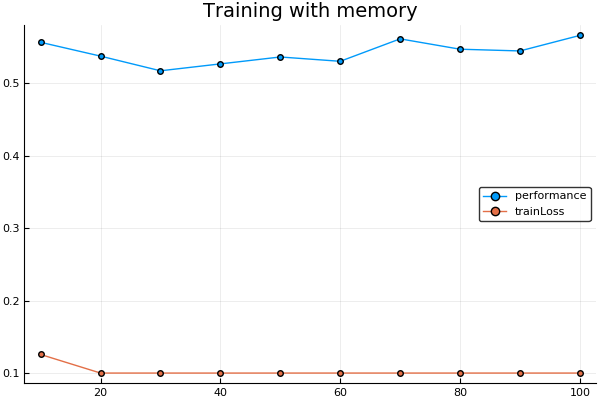

In [6]:
# Plot training

using Plots
pyplot()

plot(memHistory)
plot!(title = "Training with memory")

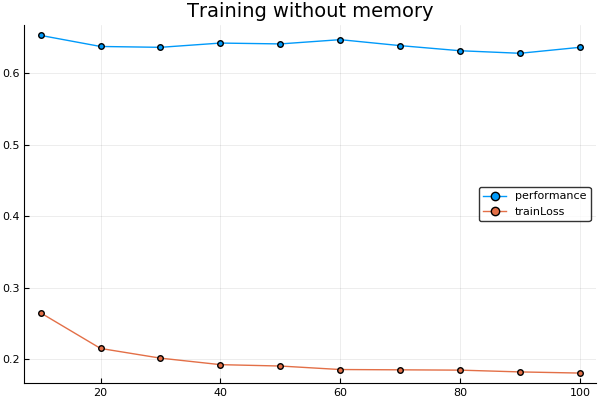

In [7]:
plot(classicHistory)
plot!(title = "Training without memory")

In [8]:
# ROC with memory

rocData = roc(test.labels, query(memory, memoryModel(test.data)))
print(rocData)
print("precision: $(precision(rocData))\n")
print("f1score: $(f1score(rocData))\n")
print("recall: $(recall(rocData))\n")
print("false positive rate: $(false_positive_rate(rocData))\n")
print("equal error rate: $((false_positive_rate(rocData) + false_negative_rate(rocData))/2)\n")

MLBase.ROCNums{Int64}
  p = 280
  n = 559
  tp = 102
  tn = 372
  fp = 187
  fn = 178
precision: 0.35294117647058826
f1score: 0.3585237258347979
recall: 0.36428571428571427
false positive rate: 0.334525939177102
equal error rate: 0.48512011244569386


In [9]:
# ROC without memory

rocData = roc(test.labels, argmax(classicModel(test.data)))
print(rocData)
print("precision: $(precision(rocData))\n")
print("f1score: $(f1score(rocData))\n")
print("recall: $(recall(rocData))\n")
print("false positive rate: $(false_positive_rate(rocData))\n")
print("equal error rate: $((false_positive_rate(rocData) + false_negative_rate(rocData))/2)\n")

MLBase.ROCNums{Int64}
  p = 280
  n = 559
  tp = 200
  tn = 0
  fp = 559
  fn = 0
precision: 0.2635046113306983
f1score: 0.4171011470281543
recall: 0.7142857142857143
false positive rate: 1.0
equal error rate: 0.5
